In [17]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd
import seaborn as sns
sns.set_theme(style="darkgrid")
from scipy.signal import medfilt
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from keras.callbacks import EarlyStopping
from keras.models import Model

In [2]:
def load_data(filename):
  return pd.read_csv(filename, usecols=range(0,7))

average_data = load_data("Well1_average_data.csv")
print(average_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5762 entries, 0 to 5761
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Time [hrs]   5762 non-null   float64
 1   W_ga [kg/s]  5762 non-null   float64
 2   P_wf [bar]   5762 non-null   float64
 3   P_wh [bar]   5762 non-null   float64
 4   W_op [kg/s]  5762 non-null   float64
 5   W_gp [kg/s]  5762 non-null   float64
 6   W_lp [kg/s]  5762 non-null   float64
dtypes: float64(7)
memory usage: 315.2 KB
None


In [18]:
X = average_data[['W_ga [kg/s]', 'P_wf [bar]', 'P_wh [bar]']]
y = average_data[['W_op [kg/s]', 'W_gp [kg/s]', 'W_lp [kg/s]']]
time = average_data['Time [hrs]']

std = StandardScaler()
X = std.fit_transform(X)

In [19]:
from sklearn.model_selection import train_test_split

# Split the dataset into main set and test set
X_main, X_test, y_main, y_test = train_test_split(X, y, train_size=4033, shuffle=False)

# Split the main set into training set and validation set
X_train, X_val, y_train, y_val = train_test_split(X_main, y_main, train_size=2304, shuffle=False)

In [6]:
# Reshape the input data for LSTM
X_train_lstm = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_val_lstm = np.reshape(X_val, (X_val.shape[0], 1, X_val.shape[1]))


In [ ]:
# Define the input layer
inputs = Input(shape=(1, 3))

# Define the LSTM layer
lstm = LSTM(32)(inputs)

# Define the output layer
outputs = Dense(3, activation='linear')(lstm)

# Create the model
lstm_model = Model(inputs=inputs, outputs=outputs)
lstm_model.compile(loss='mean_squared_error', optimizer='adam')

# Define the early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

# Train the model
history = lstm_model.fit(X_train_lstm, y_train, epochs=100, batch_size=32, validation_data=(X_val_lstm , y_val), callbacks=[early_stopping])

# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()

In [ ]:
X_lstm = X.reshape(X.shape[0], 1, X.shape[1])
y_pred = lstm_model.predict(X_lstm)


MLP NN

In [20]:
mlpnn_model = MLPRegressor(
    hidden_layer_sizes=(2),
    activation='identity',
    solver='lbfgs',
    alpha=0.0005,
    max_iter=1000,
    random_state=42
)

In [21]:
mlpnn_model.fit(X_train, y_train)

MLPRegressor(activation='identity', alpha=0.0005, hidden_layer_sizes=2,
             max_iter=1000, random_state=42, solver='lbfgs')

In [22]:
MLPNN_model = mlpnn_model.predict(X)

MV Lin Reg

In [65]:
from sklearn.multioutput import MultiOutputRegressor
MVLR_model = MultiOutputRegressor(LinearRegression(fit_intercept=True, copy_X=True))

In [66]:
MVLR_model.fit(X_train, y_train)

MultiOutputRegressor(estimator=LinearRegression())

In [67]:
MVLR= MVLR_model.predict(X)

SVR

In [68]:
from sklearn.svm import SVR


svr_model = MultiOutputRegressor(SVR(kernel='rbf', C=1.0, gamma=0.1))
svr_model.fit(X_train, y_train)

MultiOutputRegressor(estimator=SVR(gamma=0.1))

In [69]:
SVR_model = svr_model.predict(X)

KNN

In [70]:
from sklearn.neighbors import KNeighborsRegressor
knn_model = KNeighborsRegressor(n_neighbors=8, p=2)
knn_model.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=8)

In [71]:
KNN_model = knn_model.predict(X)

LSTM

In [16]:
LSTM_model = y_pred

In [34]:
MLPNN = MLPNN_model

In [81]:
def plot_flow_rates(actual_data, predicted_datas, time_data, flow_rates, model_labels):
    """
    Plots actual and predicted flow rates from given datasets.

    Parameters:
    - actual_data: The dataset containing the actual flow rates.
    - predicted_data: The dataset containing the predicted flow rates.
    - flow_rates: A list of flow rates to plot (e.g., ['W_op [kg/s]', 'W_gp [kg/s]', 'W_lp [kg/s]']).
    """

    if not isinstance(time_data, pd.DataFrame):
        time_data = pd.DataFrame(time_data)

    actual_data = actual_data.merge(time_data, left_index=True, right_index=True)

    fig, ax = plt.subplots(figsize=(14, 4))
    fig.suptitle("Prediction by multiple models (1st Five)")
    plt.axvline(x=67.21, linestyle=':', color='black')
    #adding text inside the plot
    plt.text(30, 88, 'Training data', fontsize = 10, bbox = dict(boxstyle='round', facecolor ='green', alpha=0.3))
    plt.text(80, 88, 'Testing data', fontsize = 10, bbox = dict(boxstyle='round', facecolor ='green', alpha=0.3))

    #plt.text(45, 80, 'Training data', fontsize = 10, bbox = dict(boxstyle='round', facecolor ='green', alpha=0.3))
    #plt.text(80, 80, 'Testing data', fontsize = 10, bbox = dict(boxstyle='round', facecolor ='green', alpha=0.3))
    actual_color = "black"
    colors = ["red", "green", "blue", "orange", "purple"] # Colors for the flow rates
    line_styles = ["-", "--"] # Line styles for actual and predicted data

    for i, flow_rate in enumerate(flow_rates):
        # Plot actual flow rates
        ax.plot(
            actual_data['Time [hrs]'], actual_data[flow_rate],
            line_styles[0],
            label=f"Actual {flow_rate}",
            color=actual_color
        )

        for j, predicted_data in enumerate(predicted_datas):
            label_text = f"Predicted {flow_rate}"
            if j < len(model_labels):
                label_text = f"{model_labels[j]} {label_text}"           
            ax.plot(
                actual_data['Time [hrs]'], predicted_data[flow_rate],
                line_styles[1],
                label=f"{model_labels[j]} Predicted {flow_rate}",
                color=colors[j % len(colors)]
            )

    ax.set_xlabel('Time [hrs]')
    ax.set_ylabel('Flow Rate [kg/s]')

    #_ = ax.legend(loc='lower left', fontsize=8)
    _ = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10)

    plt.show()

# Example usage
flow_rates_to_plot = ['W_op [kg/s]', 'W_gp [kg/s]', 'W_lp [kg/s]']
model_labels = ["LSTM", "MLPNN", "MVLR", "SVR", "KNN"]

In [27]:
LSTM_predictions = pd.DataFrame(LSTM_model, columns=['W_op [kg/s]', 'W_gp [kg/s]', 'W_lp [kg/s]'])
MLPNN_predictions = pd.DataFrame(MLPNN_model, columns=['W_op [kg/s]', 'W_gp [kg/s]', 'W_lp [kg/s]'])

In [72]:
MVLR_predictions = pd.DataFrame(MVLR, columns=['W_op [kg/s]', 'W_gp [kg/s]', 'W_lp [kg/s]'])
SVR_predictions = pd.DataFrame(SVR_model, columns=['W_op [kg/s]', 'W_gp [kg/s]', 'W_lp [kg/s]'])
KNN_predictions = pd.DataFrame(KNN_model, columns=['W_op [kg/s]', 'W_gp [kg/s]', 'W_lp [kg/s]'])

In [75]:
predicted_datas4 = [LSTM_predictions, MLPNN_predictions, MVLR_predictions, SVR_predictions, KNN_predictions]

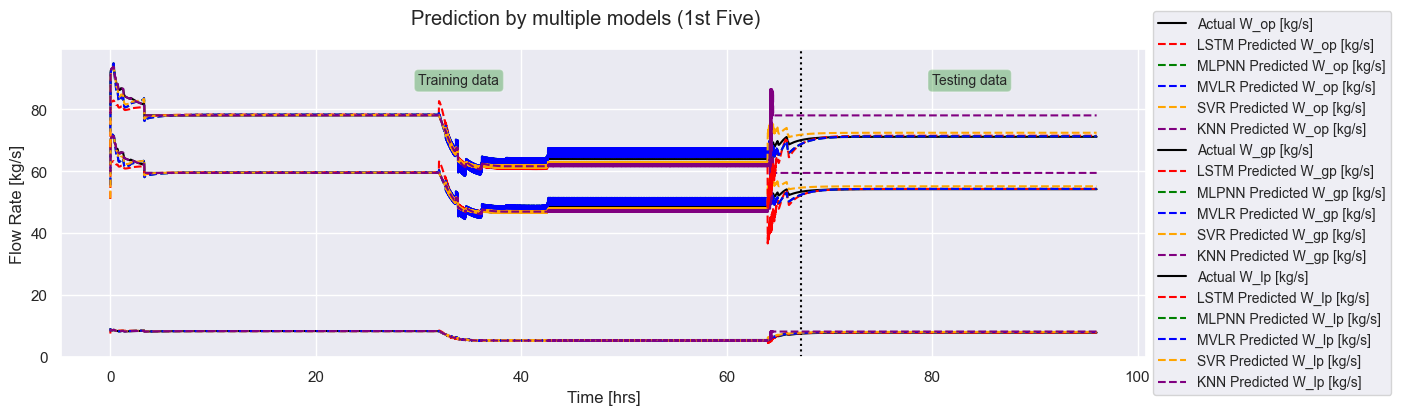

In [82]:
plot_flow_rates(y, predicted_datas4, time, flow_rates_to_plot, model_labels)